# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1</center>
## <center>Checkpoint 4 : Redes Neuronales</center> 

# Consigna

  1. Construir una **red neuronal para clasificación y mejorar su performance** mediante la búsqueda de arquitectura e hiperparámetros adecuados.
  
  2. **Evaluar la performance** de todos los modelos en entrenamiento y validación explicar todas las **métricas** y mostrar la matriz de confusión.
  
  3. **Generar predicciones** con el conjunto de test y realizar los submits correspondientes en la competencia de Kaggle.

  4. Generar las **conclusiones finales del trabajo** práctico evaluando la performance de todos los modelos entrenados.

# Inicializacion de entorno

## Librerías

In [141]:
!pip install dtreeviz


In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from datetime import datetime, timezone, timedelta
import time

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)

#redes neuronales
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier   


#metricas
from sklearn.metrics import(
    confusion_matrix,
    classification_report,
    make_scorer,
    recall_score, 
    accuracy_score,
    f1_score,
    precision_score
)

#guardado 
from google.colab import files
import pickle

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

plt.style.use('ggplot')

## Funciones

### Métricas

In [148]:
def obtener_metrica_rn(y_true, y_pred, m):
    m.update_state(y_true, y_pred)
    return m.result().numpy()

def obtener_metricas(matriz):
    tn = matriz[0][0].astype(int)
    tp = matriz[1][1].astype(int)
    fn = matriz[1][0].astype(int)
    fp = matriz[0][1].astype(int)

    accuracy= (tp+tn) / (tp+tn+fp+fn) 
    recall= tp / (tp+fn)
    precision= tp / (tp+fp)
    f1= 2*((precision*recall)/(precision+recall+ keras.backend.epsilon()))
    
    return [[str(round(accuracy,5)), str(round(recall,5)), str(round(precision,5)), str(round(f1,5))]]

def metricas_rn(true, pred, title="Matriz de confusión y métricas para una red neuronal"):

  matriz=confusion_matrix(true, pred)
 
  metrics=obtener_metricas(matriz)
  labels=['Accuracy', 'Recall', 'Precision', 'F1']
  
  plt.title(title)
  t = plt.table(cellText=metrics,
                colLabels=labels,
                bbox=(1.5, .1, 0.75, 0.75))
  t.auto_set_font_size(False)
  t.set_fontsize(11)

  #Grafico la matriz de confusión
  sns.heatmap(matriz,cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')



La métricas para evaluar el rendimiento de un modelo se calculan comparando los valores predichos frente a los reales en un conjunto de testeo, es así que surgen diferentes valores:

*   **Matriz de confusión**:


|            | predicted    |            |            |
|:----------:|:------------:|:----------:|:----------:|
|            |              |      0     |       1    |
| real       |0             | TN         | FP         |
|            |1             | FN         | TP         |

**TN**: True Negative; **FN**: False Negative; **FP**: False Positive; **TP**: True Positive



---


*   **Precisión** (precision):
    \begin{align}
        precision=\frac{TP}{TP+FP}
    \end{align}

    La *precisión* indica que cuanto más se acerca a 1, menos falsos positivos tuvo y por lo tanto todos las predicciones sobre la positiva fueron correctas. Esta métrica valora la calidad del modelo.


---


*   **Exhaustividad** (recall):
    \begin{align}
        recall=\frac{TP}{TP+FN}
    \end{align}

    Si el *exhaustividad* se acerca a 1, quiere decir que no se quedó ningún negativo verdadero afuera. Esta métrica valora la cantidad de valores que pueden identificar del modelo. 


---


*   **F1**:
    \begin{align}
        F1=2.\frac{precision.recall}{precision+recall}
    \end{align}

    *F1* se utiliza para combinar las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de ambas métricas.


---


*   **Exactitud** (accuracy):
\begin{align}
    accuracy=\frac{TP+TN}{TP++TN+FP+FN}
\end{align}

  La *exactitud* indica cual es el porcentaje de aciertos del modelo. Sin embargo no brinda mucha información sobre cómo se distribuyen los valores.

    

### Train

In [149]:
def make_rn_prediction(model, x_data, y_data=None, submission=False):
    
    y_pred_pre = model.predict(x_data)
    
    bool_pred = np.where(y_pred_pre > 0.4, 1, 0).astype(int)  # Convertir a 1 O 0

    if(not submission): 
        metricas_rn(y_data, bool_pred)
    
    ds_validacion = pd.DataFrame(bool_pred).reset_index()
    
    return ds_validacion[0]

## Datasets

In [150]:
db_train_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/TP1/processed/hotels_train.csv'
db_test_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/TP1/processed/hotels_test.csv'

df_train = pd.read_csv(db_train_url)
df_test_submission = pd.read_csv(db_test_url)

Datasets reducidos a 20 dimensiones por Random Forest features_importace

In [151]:
db_train_reduced_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/TP1/reduced/hotels_train.csv'
db_test_reduced_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/TP1/reduced/hotels_test.csv'

df_train_reduced = pd.read_csv(db_train_url)
df_test_submission_reduced = pd.read_csv(db_test_url)

# Preprocesamiento del dataframe

## Separación en x e y

Separacion entre columnas de decision y de target

In [152]:
#Creo un dataset con los features que voy a usar para clasificar
x_work = df_train.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y_work = df_train['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x_work,
                                                    y_work, 
                                                    test_size=0.25,  #proporcion 75/25
                                                    random_state=2, #semilla
                                                    stratify=df_work_train['is_canceled'].values) 

x_test_submission = df_test_submission.drop(['id'], axis='columns', inplace=False)                                            

In [153]:
#Creo un dataset con los features que voy a usar para clasificar
x_work = df_train_reduced.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y_work = df_train_reduced['is_canceled'].copy()

x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_work,
                                                    y_work, 
                                                    test_size=0.25,  #proporcion 75/25
                                                    random_state=2, #semilla
                                                    stratify=df_work_train['is_canceled'].values) 

x_test_submission_reduced = df_test_submission_reduced.drop(['id'], axis='columns', inplace=False)  

# Entrenamiento y prediccion de redes

In [154]:
best_model_submission = {"name": "", "model": None}

Se buscan generar multiples modelos para distintas arquitecturas evaluando cual está mejor optimizado

Para ello utilizaremos el F1-score

In [155]:
def f1_score(y_true, y_pred):
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    recall = true_positives / (possible_positives + keras.backend.epsilon())

    f1_score = 2 * (precision * recall) / (precision + recall + keras.backend.epsilon())
    return f1_score

## Arquitectura 1: Bi-capa mononeuronal

Una capa de entrada y una de salida con función de activación sigmoidea. Ambas de una neurona



In [156]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))
d_in=len(x_train.columns)

def get_arq1():
  return keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,)),
    keras.layers.Dense(1, activation='sigmoid')])

arq_1 = get_arq1()
arq_1.summary()

Model: "sequential_2412"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7225 (Dense)          (None, 1)                 40        
                                                                 
 dense_7226 (Dense)          (None, 1)                 2         
                                                                 
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


### Modelo 1: SGD + binary crossentropy

Optimizada según F1-score con Stochastic Gradient Descent y función de perdida de entropía cruzada binaria

In [165]:
def create_m1(epochs=100, batch_size=64, learning_rate=0.01):
  model_1 = get_arq1()
  model_1.compile(
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate), 
    loss='binary_crossentropy', 
    # metricas para ir calculando en cada iteracion o batch 
    metrics=[f1_score], 
  )
  model_1.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=False)
  return model_1

Optimizo los hiperparametros "epochs", "batch_size" y "learning_rate" con GridSearch

In [166]:
# Creo el modelo en KerasClassifier
model = KerasClassifier(build_fn=create_m1, verbose=0)

# Rangos de hiperparámetros para la búsqueda aleatoria
param_grid = {
    'epochs': [100, 200, 300],
    'batch_size': [18, 32, 64],
}

# Realizar la búsqueda aleatoria
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(x_train, y_train)

# Obtengo el mejor modelo
print("Mejor modelo: %f %s" % (grid_result.best_score_, grid_result.best_params_))

KeyboardInterrupt: 

Veo las metricas:

In [ ]:
make_rn_prediction(grid, x_test, y_test)

### Modelo 2: ADAM + Binary Crossentropy + Early stopping

Optimizada según F1-score con Adam y función de perdida binary crossentropy

In [167]:
def create_m2(epochs=100, batch_size=64):
  model_2 = get_arq1()
  model_2.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    # metricas para ir calculando en cada iteracion o batch 
    metrics=[f1_score], 
  )
  model_2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=False)
  return model_2

Optimizo hiperparámetros con GridSearch 3 folds y EarlyStopping con 15 epochs de paciencia

In [168]:
# Creo el modelo en KerasClassifier
model_2 = KerasClassifier(build_fn=create_m2, verbose=0)

# Rangos de hiperparámetros para la búsqueda aleatoria
param_grid = {
    'epochs': [100, 200, 300],
    'batch_size': [18, 32, 64]
}

#Defino el early stopping según la perdida de validación
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Realizar la búsqueda aleatoria
grid = GridSearchCV(estimator=model_2, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(x_train, y_train, callbacks=[early_stopping])

# Obtengo el mejor modelo
print("Mejor modelo: %f %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


KeyboardInterrupt: 

## Arquitectura 2: Bi-capa multi-neuronal

Una capa de entrada y una de salida con función de activación sigmoidea. Cada capa con multiples neuronas



In [ ]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))
d_in=len(x_train.columns)

def get_arq2():
  return keras.Sequential([
    keras.layers.Dense(16, input_shape=(d_in,), activation='relu'),
    keras.layers.Dense(cant_clases, activation='sigmoid')
  ])

arq_2 = get_arq2()
arq_2.summary()

Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_230 (Dense)           (None, 16)                640       
                                                                 
 dense_231 (Dense)           (None, 2)                 34        
                                                                 
Total params: 674
Trainable params: 674
Non-trainable params: 0
_________________________________________________________________


### Modelo 1: SGD + binary crossentropy + Grid Search

Optimizada según F1-score con Stochastic Gradient Descent y función de perdida de entropía cruzada binaria

In [ ]:
def create_arq2_m1(epochs=100, batch_size=64):
  model_1 = get_arq2()
  model_1.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01), 
    loss='binary_crossentropy', 
    # metricas para ir calculando en cada iteracion o batch 
    metrics=['accuracy'], 
  )
  model_1.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=False)
  return model_1

Optimizo los hiperparametros "epochs", "batch_size" y "learning_rate" con GridSearch

In [ ]:
# Creo el modelo en KerasClassifier
arq2_model_1 = KerasClassifier(build_fn=create_arq2_m1, verbose=0)

# Rangos de hiperparámetros para la búsqueda aleatoria
param_grid = {
    'epochs': [100, 200],
    'batch_size': [32, 64]
}

#Defino el early stopping según la perdida de validación
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Realizar la búsqueda aleatoria
grid = GridSearchCV(estimator=arq2_model_1, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_train, y_train, callbacks=[early_stopping])

# Obtengo el mejor modelo
print("Mejor modelo: %f %s" % (grid_result.best_score_, grid_result.best_params_))

ValueError: ignored

### Modelo 2: ADAM + Binary Crossentropy + Early stopping

Optimizada según F1-score con Stochastic Gradient Descent y función de perdida Binary hinge

In [ ]:
def arq_2_create_m2(epochs=100, batch_size=64):
  model_2 = get_arq2()
  model_2.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    # metricas para ir calculando en cada iteracion o batch 
    metrics=[f1_score], 
  )
  model_2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=False)
  return model_2

In [ ]:
# Creo el modelo en KerasClassifier
arq_2_model_2 = KerasClassifier(build_fn=arq_2_create_m2, verbose=0)

# Rangos de hiperparámetros para la búsqueda aleatoria
param_grid = {
    'epochs': [100, 200, 300],
    'batch_size': [18, 32, 64]
}

#Defino el early stopping según la perdida de validación
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Realizar la búsqueda aleatoria
grid = GridSearchCV(estimator=arq_2_model_2, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(x_train, y_train, callbacks=[early_stopping])

# Obtengo el mejor modelo
print("Mejor modelo: %f %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


## Arquitectura 3: relu-softmax

In [ ]:
# One hot encoding
enc = OneHotEncoder()
y_train_encoder = enc.fit_transform(y_train[:, np.newaxis]).toarray()
y_test_encoder = enc.transform(y_test[:, np.newaxis]).toarray()

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Red neuronal secuencial con dos capas densas de entrada y salida, esta ultima con funcion sigmoidea y la capa de entrada con función de activación relu e inicializador de kernel uniforme. Cada capa cuenta con dos neuronas

In [ ]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))
d_in=len(x_train.columns)

arq_3 = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 3 salidas, activación relu
    keras.layers.Dense(2,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(cant_clases, activation='softmax')])

arq_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 2)                 80        
                                                                 
 dense_23 (Dense)            (None, 2)                 6         
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


SGD como otpimizador segun f1, crossentropy para variables categoricas 
100 epochs, 16 batchs

In [ ]:
arq_3.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.001), 
  loss='categorical_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=[f1_score], 
)

cant_epochs=100
modelo_2_historia = arq_3.fit(x_train_scaled,y_train_encoder,epochs=cant_epochs,batch_size=16,verbose=False)

In [ ]:
y_pred_a2 = arq_3.predict(x_test_scaled)
y_pred_a2_clases=np.argmax(y_pred_a2,axis=1).tolist()
y_real_clases=np.argmax(y_test_encoder,axis=1).tolist()

347/347 [==============================] - 0s 351us/step


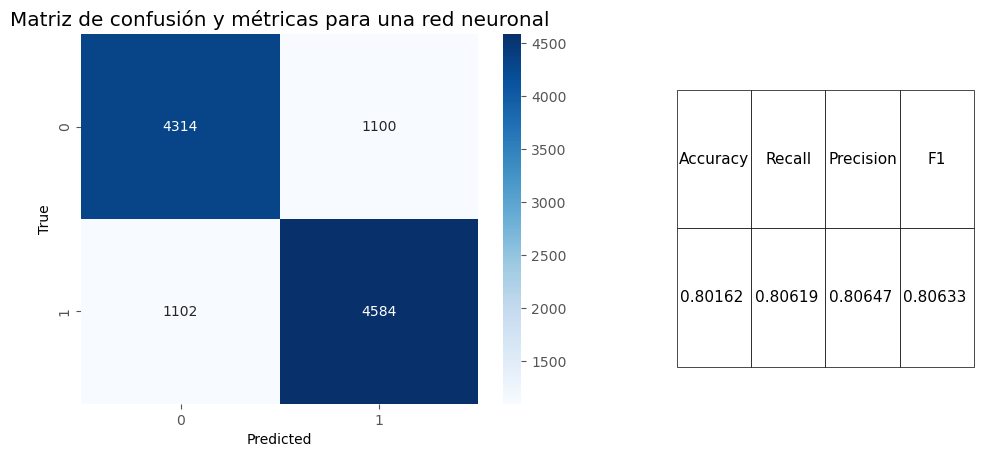

In [ ]:
ds_validacion_m2=pd.DataFrame(y_pred_a2_clases,y_real_clases).reset_index()
ds_validacion_m2.columns=['y_pred','y_real']

metricas_rn(ds_validacion_m2.y_real, ds_validacion_m2.y_pred)

## Arquitectura 4: Tricapa

Para este caso, utilizamos una capa de entrada de 64 neuronas, una capa intermedia de 32 y una capa de salida nuevamente con una función de activación sigmoideal, dado que se trata de una clasificación.
Para la optimización,  probamos con adma y una función de perdida binary crossentropy como en el modelo 1.

### Modelo 1: adam, binary_crossentropy, f1_score

In [169]:
cant_clases=len(np.unique(y_train))
d_in=len(x_train.columns)

def create_model_1_arq_4():
    modelo= keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(d_in,)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    modelo.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=[f1_score]
     )

    modelo.summary()
    
    return modelo

Para el modelo 3 utilizamos 40 epochs y un tamaño para el batch de 300, ademas de un early stopping para evitar un posible overfitting.

In [171]:
early_stopping = EarlyStopping(monitor='f1_score', patience = 1)

modelo_1_arq_4 = create_model_1_arq_4()

historia = modelo_1_arq_4.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size= 300,
    verbose=False, 
    callbacks = [early_stopping]
)

Model: "sequential_2424"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7250 (Dense)          (None, 64)                2560      
                                                                 
 dense_7251 (Dense)          (None, 32)                2080      
                                                                 
 dense_7252 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


347/347 [==============================] - 0s 351us/step


0        1
1        0
2        1
3        1
4        1
        ..
11095    1
11096    1
11097    1
11098    0
11099    0
Name: 0, Length: 11100, dtype: int64

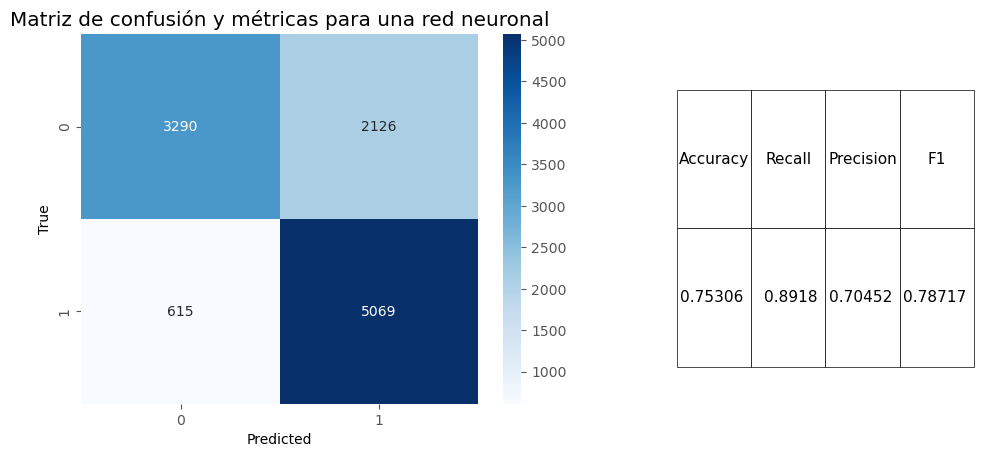

In [172]:
make_rn_prediction(modelo_1_arq_4, x_test, y_test)

### Modelo 2: nadam, mse, accuracy con GridSearch

In [173]:
cant_clases=len(np.unique(y_train_reduced))
d_in = len(x_train_reduced.columns)

En este caso mantuvimos la arquitectura del modelo 3 pero utilizando como optimizador a nadam, como funcion de perdida a MSE, y métrica principal la exactitud.

In [174]:
def create_model_2_arq_4():
    modelo= keras.Sequential([
      keras.layers.Dense(64, activation='relu', input_shape=(d_in,)),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')
    ])
    
    modelo.compile(
      optimizer='nadam', 
      loss='mse', 
      metrics=["accuracy"], 
    )
    
    return modelo

Para optener la cantidad de epochs y el tamaño de batch adecuado, realizamos una validación cruzada con Grid Search. Es importe destacar que para este caso, se utilizó un dataset reducido en su dimensión a partir de la importacia de atributos conseguida en el CHP3 por Random Forest.

In [ ]:
modelo_cv = KerasClassifier(build_fn=create_model_2_arq_4)

epochs = [100, 200, 300]
batches = [20, 40, 60]

param_grid = dict( epochs=epochs, batch_size=batches)

print(param_grid)

grid = GridSearchCV(estimator=modelo_cv, param_grid=param_grid)
grid_result = grid.fit(x_train_reduced, y_train_reduced, callbacks = [early_stopping])

{'epochs': [100, 200, 300], 'batch_size': [20, 40, 60]}
Epoch 1/100
1332/1332 [==============================] - 1s 569us/step - loss: 0.1668 - accuracy: 0.7532
Epoch 2/100
1332/1332 [==============================] - 1s 579us/step - loss: 0.1450 - accuracy: 0.7907
Epoch 3/100
1332/1332 [==============================] - 1s 572us/step - loss: 0.1355 - accuracy: 0.8024
Epoch 4/100
1332/1332 [==============================] - 1s 580us/step - loss: 0.1347 - accuracy: 0.8033
Epoch 5/100
1332/1332 [==============================] - 1s 580us/step - loss: 0.1283 - accuracy: 0.8119
Epoch 6/100
1332/1332 [==============================] - 1s 584us/step - loss: 0.1281 - accuracy: 0.8095
Epoch 7/100
1332/1332 [==============================] - 1s 565us/step - loss: 0.1243 - accuracy: 0.8185
Epoch 8/100
1332/1332 [==============================] - 1s 577us/step - loss: 0.1230 - accuracy: 0.8201
Epoch 9/100
1332/1332 [==============================] - 1s 583us/step - loss: 0.1207 - accuracy: 0.8235

In [ ]:
print("Mejor modelo: %f %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor modelo: 0.845105 {'batch_size': 40, 'epochs': 300}


278/278 [==============================] - 0s 344us/step


0        1
1        0
2        1
3        1
4        1
        ..
11095    1
11096    1
11097    1
11098    0
11099    1
Name: 0, Length: 11100, dtype: int64

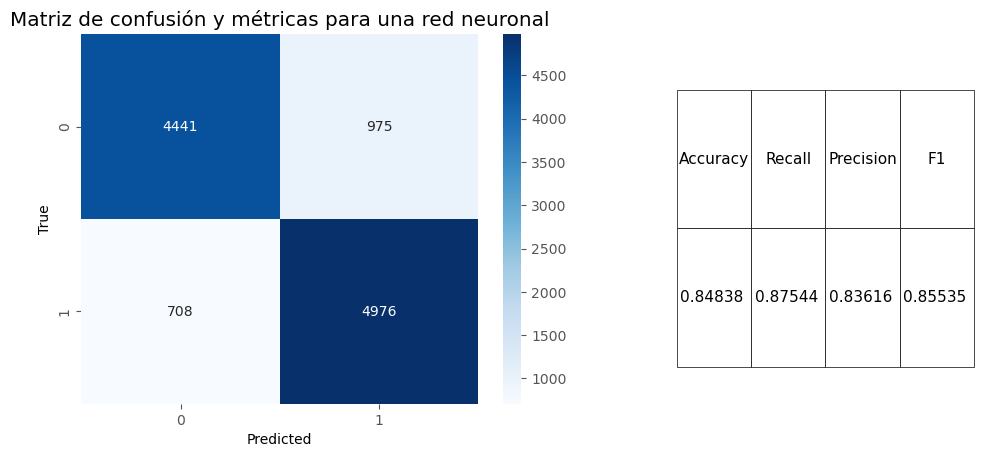

In [ ]:
modelo_2_arq_4= grid_result.best_estimator_
make_rn_prediction(modelo_2_arq_4, x_test_reduced, y_test_reduced)

In [ ]:
best_model_submission["name"] = "RN-Multicapa-nadam-mse-GridSearch"
best_model_submission["model"] = modelo_2_arq_4

# Submission

Se realiza una prediccion a partir de las columnas de decision del dataframe de test

In [ ]:
y_pred = make_rn_prediction(best_model_submission["model"], x_test_submission, submission=True)
df_submission = pd.DataFrame({"id": df_test_submission["id"], "is_canceled": y_pred})
df_submission

664/664 [==============================] - 0s 353us/step


,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [ ]:
file_name = 'submission-' + best_model_submission["name"] + '-' + datetime.now(timezone(timedelta(hours=-3))).strftime("%d-%m-%H:%M") + '.csv'
df_submission.to_csv(file_name, encoding = 'utf-8-sig', index=False) 
files.download(file_name)

# Model save

In [ ]:
model_file_name = best_model_submission["name"] + ".pickle"

# save model
pickle.dump(best_model_submission["model"], open(model_file_name, "wb"))

INFO:tensorflow:Assets written to: ram://2c017b32137045d29ac202fb4cc2b536/assets


INFO:tensorflow:Assets written to: ram://2c017b32137045d29ac202fb4cc2b536/assets
